In [439]:
# Cell 1: Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
import joblib
import requests
from datetime import datetime
import json
from sklearn.preprocessing import StandardScaler

In [440]:
# Cell 2: Load and Preprocess Data
# Load the dataset
df = pd.read_csv('coconut_irrigation_data_with_water_level_8.csv')

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Convert soil type to numerical
soil_type_mapping = {
    'Lateritic': 1,
    'Sandy Loam': 2,
    'Cinnamon Sand': 3,
    'Red Yellow Podzolic': 4,
    'Alluvial': 5
}

df['Soil Type'] = df['Soil Type'].map(soil_type_mapping)
joblib.dump(soil_type_mapping, 'soil_type_mapping.pkl')

['soil_type_mapping.pkl']

In [441]:
# Cell 3: Define Water Level Categories
def categorize_water_level(water_level):
    if 50 <= water_level <= 100:
        return 1  # High water need
    elif 30 <= water_level < 50:
        return 2  # Moderate water need
    elif 10 <= water_level < 30:
        return 3  # Low water need
    else:
        return 0  # No water needed

# Apply categorization
df['Water Level Category'] = df['Water Level (liters)'].apply(categorize_water_level)

In [442]:
# Cell 4: Prepare Features and Target
# Select features including Soil Type
X = df[[
    'Soil Type',
    'Soil Moisture (10 cm) (%)',
    'Soil Moisture (20 cm) (%)',
    'Soil Moisture (30 cm) (%)',
    'Plant Age (years)',
    'Temperature (°C)',
    'Humidity (%)',
    'Rainfall (mm)'
]]
y = df['Water Level Category']

In [443]:
# Cell 5: Apply SMOTE and Split Data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42)

In [444]:
# Cell 6: Define Evaluation Functions
def get_water_level_range_string_from_category(category):
    if category == 1:
        return "50-100L\n(High)"
    elif category == 2:
        return "30-50L\n(Moderate)"
    elif category == 3:
        return "10-30L\n(Low)"
    elif category == 0:
        return "0L\n(None)"
    else:
        raise ValueError("Invalid category. Must be 0, 1, 2, or 3.")

def evaluate_model(model):
    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Model: {model.__class__.__name__}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    if isinstance(model, RandomForestClassifier):
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        #print("\nFeature Importance:")
        #print(feature_importance)
    
    # Visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_correct = conf_matrix.diagonal()
    class_total = conf_matrix.sum(axis=1)
    class_accuracy = class_correct / class_total * 100
    
    water_level_labels = [get_water_level_range_string_from_category(i) for i in range(4)]
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
    
    # Bar plot
    bars = ax1.bar(range(4), class_accuracy, color=colors)
    ax1.set_title(f'Prediction Accuracy by Water Need Level\n{model.__class__.__name__}', pad=20)
    ax1.set_xlabel('Water Need Category (Liters)')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xticks(range(4))
    ax1.set_xticklabels(water_level_labels, rotation=0)
    ax1.set_ylim([0, 100])
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    # Pie chart
    class_percentages = (class_total / class_total.sum()) * 100
    wedges, texts, autotexts = ax2.pie(class_percentages,
                                       labels=water_level_labels,
                                       colors=colors,
                                       autopct='%1.1f%%',
                                       startangle=90)
    
    plt.setp(autotexts, size=8, weight="bold")
    plt.setp(texts, size=8)
    ax2.set_title(f'Distribution of Water Need Categories\n{model.__class__.__name__}', pad=20)
    
    legend_labels = [
        '0L (No water needed)',
        '50-100L (High water need)',
        '30-50L (Moderate water need)',
        '10-30L (Low water need)'
    ]
    ax2.legend(wedges, legend_labels,
              title="Water Need Categories",
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.tight_layout()
    plt.show()
    
    # Save model and features
    model_filename = f"{model.__class__.__name__.lower()}water_model.pkl"
    joblib.dump(model, model_filename)
    joblib.dump(X.columns.tolist(), 'feature_columns.pkl')
    print(f"\nModel exported as: {model_filename}")
    print("======================================================================================================================================")

In [ ]:
# Cell 7: Train Models
models = [
    RandomForestClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    LogisticRegression(
            random_state=42,
            max_iter=2000,  # Increased iterations
            solver='lbfgs',
            multi_class='multinomial',
            C=1.0,  # Regularization strength
            class_weight='balanced')
]

for model in models:
    evaluate_model(model)

SyntaxError: keyword argument repeated: max_iter (3047511984.py, line 6)

In [ ]:
def plot_model_comparison(models):
    # Train and evaluate all models
    results = []
    
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred) * 100
        
        results.append({
            'Model': model.__class__.__name__,
            'Accuracy': accuracy
        })
    
    # Create bar plot
    plt.figure(figsize=(10, 6))
    
    # Extract model names and accuracies
    model_names = [r['Model'] for r in results]
    accuracies = [r['Accuracy'] for r in results]
    colors = ['#2ecc71', '#3498db', '#9b59b6']  # Colors for each model
    
    # Create bars
    bars = plt.bar(model_names, accuracies, color=colors, width=0.6)
    
    # Add percentage labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom',
                fontweight='bold')
    
    plt.title('Model Accuracy Comparison', pad=20, fontsize=14)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    
    # Set y-axis limits
    plt.ylim(0, 100)
    
    # Add horizontal lines for better readability
    plt.axhline(y=90, color='gray', linestyle='--', alpha=0.3)
    plt.axhline(y=80, color='gray', linestyle='--', alpha=0.3)
    plt.axhline(y=70, color='gray', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

c:\Users\sadee\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sadee\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


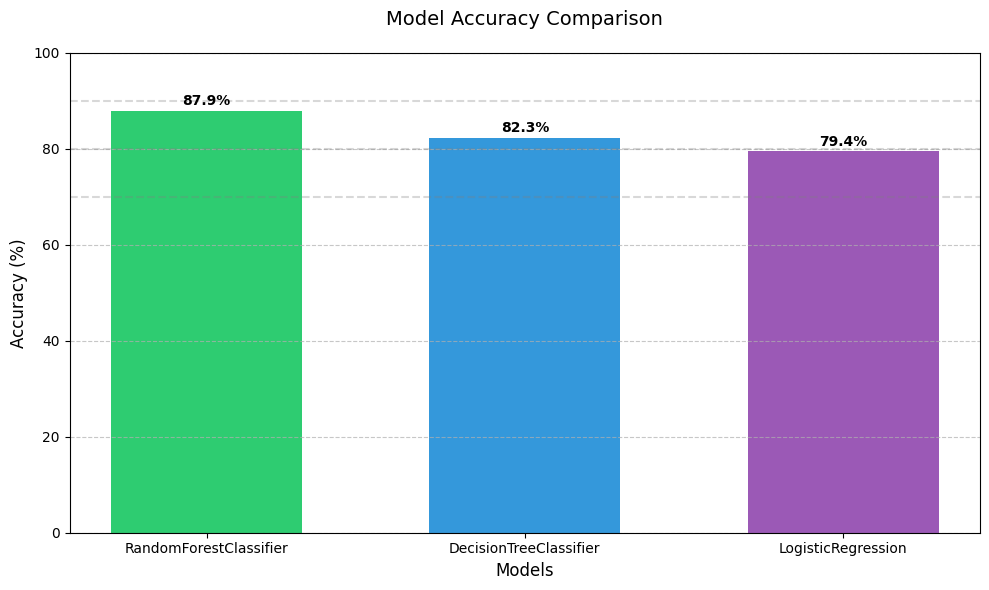

In [ ]:
plot_model_comparison(models)

In [ ]:
# Cell 8: Updated Model Selection with Scaling

def find_best_model():
    """
    Test all models with proper scaling and return the one with highest accuracy
    """
    # Initialize scaler
    scaler = StandardScaler()
    
    # Scale the features
    X_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Save scaler for predictions
    joblib.dump(scaler, 'scaler.pkl')
    
    # Define models with optimized parameters
    models = {
        'RandomForest': RandomForestClassifier(
            random_state=42,
            n_estimators=100
        ),
        'DecisionTree': DecisionTreeClassifier(
            random_state=42,
            max_depth=10
        ),
        'LogisticRegression': LogisticRegression(
            random_state=42,
            max_iter=2000,  # Increased iterations
            solver='lbfgs',
            multi_class='multinomial',
            C=1.0,  # Regularization strength
            class_weight='balanced'
        )
    }
    
    best_accuracy = 0
    best_model = None
    best_model_name = None
    
    for name, model in models.items():
        # Train model on scaled data
        model.fit(X_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_model_name = name
    
    print(f"\nBest Model: {best_model_name}")
    print(f"Accuracy: {best_accuracy:.4f}")
    
    # Save best model
    joblib.dump(best_model, 'best_model.pkl')
    return best_model, best_model_name

def predict_water_need(soil_type, moisture_10cm, moisture_20cm, moisture_30cm,
                      plant_age, temperature, humidity, rainfall):
    """
    Predict using the best performing model with scaled data
    """
    try:
        # Load the model, scaler, and mappings
        model = joblib.load('best_model.pkl')
        scaler = joblib.load('scaler.pkl')
        soil_mapping = joblib.load('soil_type_mapping.pkl')
        
        # Create input data
        new_data = pd.DataFrame({
            'Soil Type': [soil_mapping[soil_type]],
            'Soil Moisture (10 cm) (%)': [moisture_10cm],
            'Soil Moisture (20 cm) (%)': [moisture_20cm],
            'Soil Moisture (30 cm) (%)': [moisture_30cm],
            'Plant Age (years)': [plant_age],
            'Temperature (°C)': [temperature],
            'Humidity (%)': [humidity],
            'Rainfall (mm)': [rainfall]
        })
        
        # Scale the input data
        new_data_scaled = scaler.transform(new_data)
        
        # Make prediction
        prediction = model.predict(new_data_scaled)[0]
        probabilities = model.predict_proba(new_data_scaled)[0]
        
        return prediction, probabilities
        
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None, None

In [ ]:
df.head(6)

,Date,Soil Type,Soil Moisture (10 cm) (%),Soil Moisture (20 cm) (%),Soil Moisture (30 cm) (%),Plant Age (years),Temperature (°C),Humidity (%),Rainfall (mm),Rain Status (0/1),Irrigation Status (0/1),Water Level (liters),Water Level Category
0,2020-04-22,4,36.867627,21.865596,38.507507,10,25.307124,73.814358,2.578859,1,0,0.000000,0
1,2023-12-03,1,59.917928,52.812786,56.767034,10,25.307124,73.814358,0.000000,0,0,0.000000,0
2,2020-08-29,4,22.763336,16.576376,22.598885,7,29.987019,78.942960,0.000000,0,1,98.103466,1
3,2021-03-18,3,46.065484,61.316373,43.299673,7,29.987019,78.942960,14.848499,1,0,0.000000,0
4,2023-05-27,2,19.697741,31.192243,29.383629,6,32.358858,67.739955,0.000000,0,1,76.159349,1
5,2021-05-14,5,30.295711,62.770718,73.610180,6,32.358858,67.739955,0.000000,0,0,36.473645,2


In [ ]:
def get_weather_data(city_name, api_key):
    """
    Fetch weather data from OpenWeatherMap API
    """
    base_url = "http://api.openweathermap.org/data/2.5/weather"
    
    try:
        # Make API request
        params = {
            'q': city_name,
            'appid': api_key,
            'units': 'metric'  # For Celsius
        }
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        weather_data = response.json()
        
        # Extract relevant data
        return {
            'temperature': weather_data['main']['temp'],
            'humidity': weather_data['main']['humidity'],
            # 'rainfall': 1 if 'rain' in weather_data else 0,
            'rainfall': weather_data.get('rain', {}).get('1h', 0)  # Rain in last 12 hours
        }
    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return None

def predict_with_weather(soil_type, moisture_10cm, moisture_20cm, moisture_30cm, 
                        plant_age, city_name, api_key):
    """
    Make prediction using real-time weather data
    """
    # Get weather data
    weather_data = get_weather_data(city_name, api_key)
    
    if weather_data is None:
        return None, None
    
    # Create input data for prediction
    input_data = {
        'soil_type': soil_type,
        'moisture_10cm': moisture_10cm,
        'moisture_20cm': moisture_20cm,
        'moisture_30cm': moisture_30cm,
        'plant_age': plant_age,
        'temperature': weather_data['temperature'],
        'humidity': weather_data['humidity'],
        'rainfall': weather_data['rainfall']
    }
    
    # Make prediction
    prediction, probabilities = predict_water_need(**input_data)
    
    return prediction, probabilities, input_data, weather_data

def visualize_prediction_with_weather(prediction, probabilities, input_data, weather_data, model_name):
    """
    Enhanced visualization including weather data
    """
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f'Prediction Results using {model_name}', fontsize=14, fontweight='bold', y=1.02)
    
    gs = plt.GridSpec(1, 2, width_ratios=[1.5, 1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    
    categories = ['No Water\n(0L)', 'High\n(50-100L)', 'Moderate\n(30-50L)', 'Low\n(10-30L)']
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']
    
    bars = ax1.bar(categories, probabilities * 100, color=colors)
    ax1.set_title('Water Need Prediction Probabilities', pad=20)
    ax1.set_xlabel('Water Need Categories')
    ax1.set_ylabel('Probability (%)')
    ax1.set_ylim([0, 100])
    
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom')
    
    ax2.axis('off')
    summary_text = [
        f"Prediction Summary",
        f"{'=' * 40}",
        f"Model: {model_name}",
        f"Soil Type: {input_data['soil_type']}",
        f"Predicted Need: {get_water_level_range_string_from_category(prediction)}",
        f"\nEnvironmental Conditions:",
        f"Temperature: {input_data['temperature']:.1f}°C",
        f"Humidity: {input_data['humidity']:.1f}%",
        f"Plant Age: {input_data['plant_age']} years",
        f"Rain Status: {'Yes' if input_data['rainfall'] else 'No'}",
        f"\nWeather Details:",
        f"Rainfall (1h): {weather_data['rainfall']:.1f}mm",
        f"\nConfidence Level:",
        f"Prediction Confidence: {max(probabilities)*100:.1f}%",
        f"\nLast Updated: {datetime.now().strftime('%Y-%m-%d %H:%M')}"
    ]
    
    ax2.text(0, 0.95, '\n'.join(summary_text),
             fontsize=10, fontfamily='monospace',
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

#Main App
def main():


    api_key = "5dd16e6569f3cdae6509d32002b9dc67"
    city_name = "Bandarawela"
    
    # Get best model
    best_model = find_best_model()
    
    if isinstance(best_model, tuple):
        model_name = best_model[0].__class__.__name__
        model_to_use = best_model[0]
    else:
        model_name = best_model.__class__.__name__
        model_to_use = best_model
    
    # Make prediction with real-time weather
    prediction, probabilities, input_data, weather_data = predict_with_weather(
        soil_type='Lateritic',
        moisture_10cm=14.477,
        moisture_20cm=24.64,
        moisture_30cm=36.25,
        plant_age=5,
        city_name=city_name,
        api_key=api_key
    )
    
    if prediction is not None and probabilities is not None:
        visualize_prediction_with_weather(
            prediction, probabilities, input_data, weather_data, model_name
        )
        
        # Print detailed numerical results
        print("\nDetailed Prediction Results:")
        print("-" * 50)
        print(f"Model Used: {model_name}")
        print(f"Predicted Category: {prediction}")
        print("\nCategory Probabilities:")
        categories = ['No Water', 'High (50-100L)', 'Moderate (30-50L)', 'Low (10-30L)']
        for cat, prob in zip(categories, probabilities):
            print(f"{cat}: {prob*100:.1f}%")
    else:
        print("Error in prediction. Please check input data.")

if __name__ == "__main__":
    main()

AttributeError: 'list' object has no attribute 'items'